- zqのMSEを調べる
- 学習データのbook_indicesの最頻値からzqを取得
- テストデータのzqのMSEを計算

In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import sys
from glob import glob
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sys.path.append(".")
from src.model import SQVAE
from src.utils import yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
model_type = "sqvae"
dataset_num = 3
video_num = "test"

# load preds
# data_root = f"../datasets/dataset{dataset_num:02d}/train/{video_num:02d}"
data_root = f"../datasets/dataset{dataset_num:02d}/test_other/test"
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

# count labels
labels = {}
for result in results:
    key = result["key"]
    video_num, n_frame, _id = key.split("_")
    key = f"{video_num}_{_id}"

    if key not in labels:
        labels[key] = []
    labels[key].append(result["label"])

# get most frequent labels
data = []
for key, val in labels.items():
    unique, counts = np.unique(val, return_counts=True)
    maxidx = np.argmax(counts)
    label = unique[maxidx].item()
    data.append([key, label])

# save
# path = f"../datasets/dataset{dataset_num:02d}/annotation/role_train_{video_num}.txt"
path = f"../datasets/dataset{dataset_num:02d}/annotation/role_test_other.txt"
np.savetxt(path, data, fmt="%s", delimiter=" ")

In [3]:
# test
model_type = "sqvae"
dataset_num = 3
if dataset_num == 3:
    v = 0
elif dataset_num == 4:
    v = 1
elif dataset_num == 5:
    v = 2
checkpoint_dir = f"models/individual/{model_type}/version_{v}"


# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

# load preds
data_root = f"../datasets/dataset{dataset_num:02d}/test/{video_num:02d}"
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

img_dir = f"../datasets/dataset{dataset_num:02d}/images"
os.makedirs(img_dir, exist_ok=True)

In [4]:
data_dirs_train = glob(f"../datasets/dataset{dataset_num:02d}/train/*/")
results = []
for data_dir in tqdm(data_dirs_train):
    video_num = os.path.basename(os.path.dirname(data_dir))
    if video_num != "06":
        print(video_num)
        continue

    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

  0%|          | 0/2 [00:00<?, ?it/s]

12


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


In [5]:
book_counts = {c: np.zeros((n_pts * 2, config.book_size)) for c in range(config.n_clusters)}
for result in results:
    label = result["label"]
    book_indics = result["book_idx"]
    book_counts[label][np.arange(len(book_indics)), book_indics] += 1

0


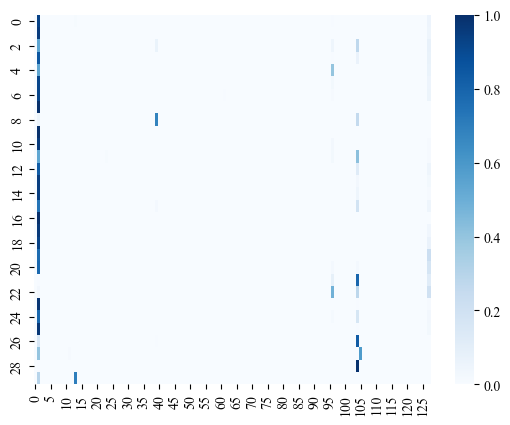

1


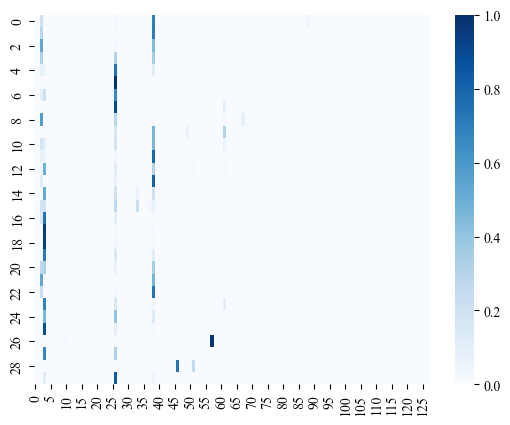

2


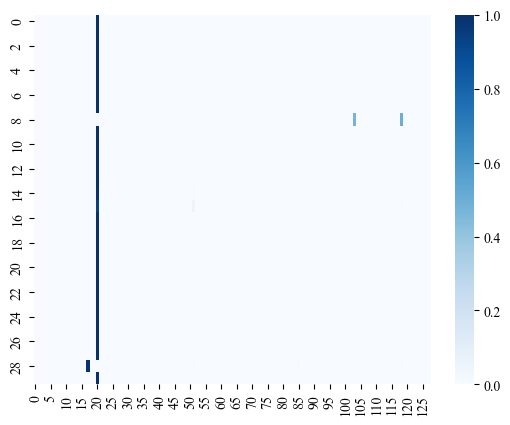

3


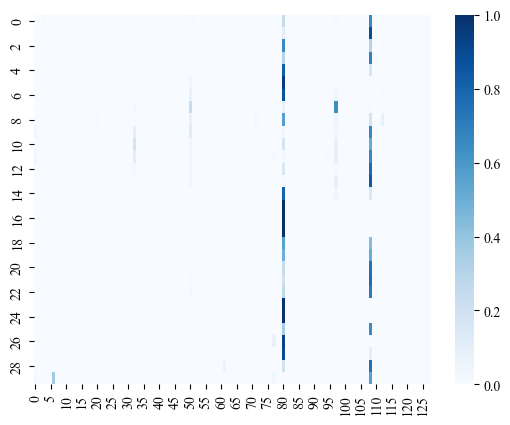

4


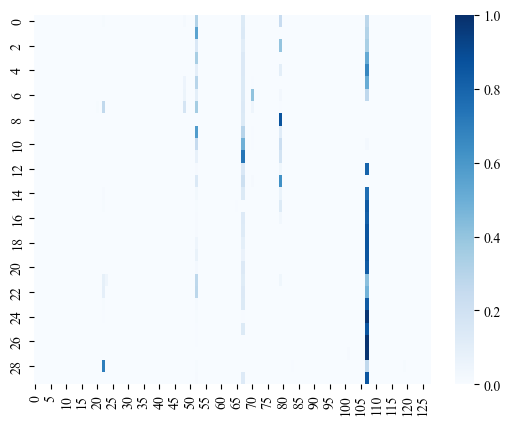

In [6]:
for label in range(config.n_clusters):
    counts = book_counts[label]
    ratio = counts / counts.sum(axis=1, keepdims=True)
    print(label)
    sns.heatmap(ratio, cmap="Blues", vmax=1.0)
    plt.show()

0


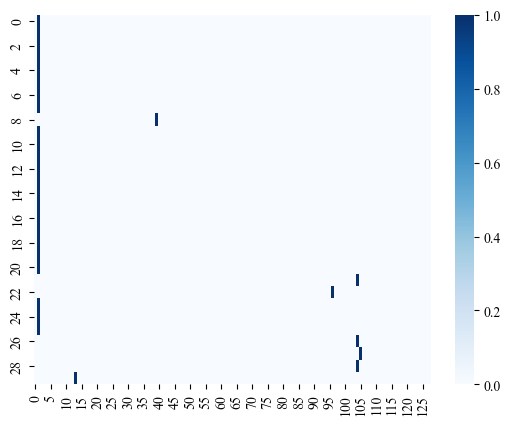

1


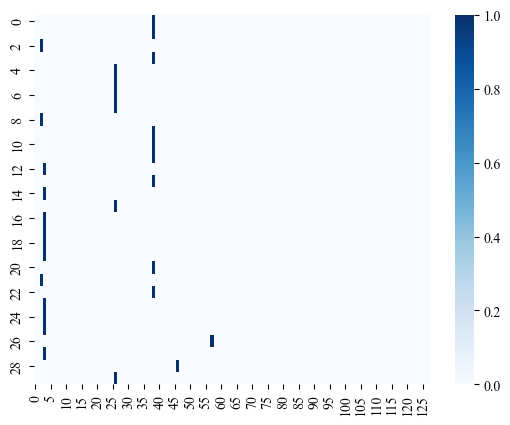

2


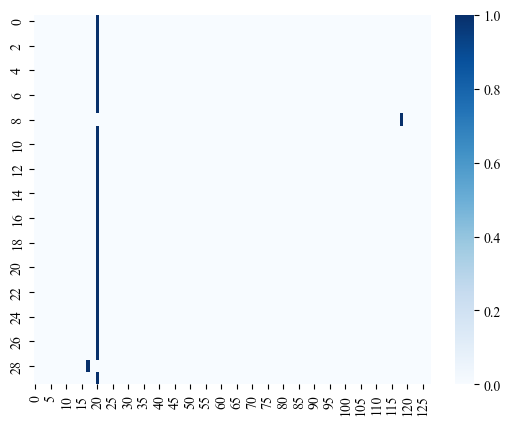

3


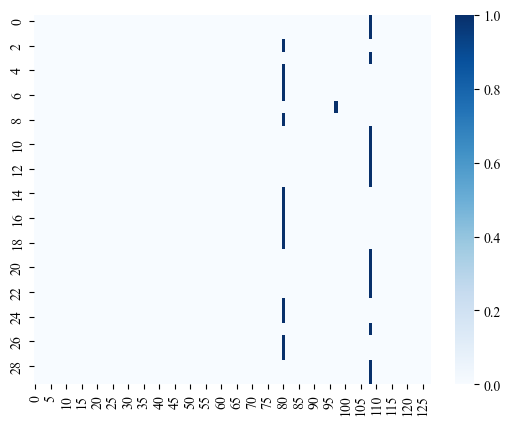

4


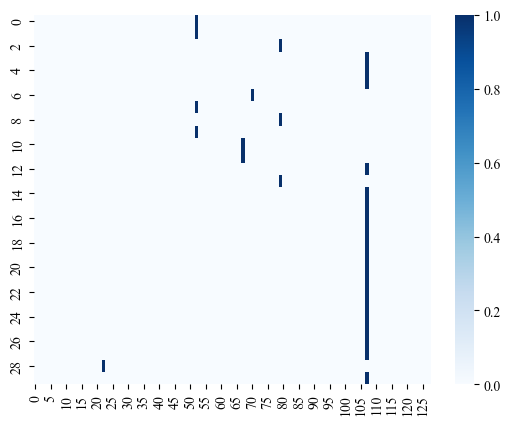

In [7]:
mode_one_hot = {}
for label in range(config.n_clusters):
    counts = book_counts[label]
    argmax = counts.argmax(axis=1)
    one_hot = np.eye(config.book_size)[argmax]
    print(label)
    sns.heatmap(one_hot, cmap="Blues", vmax=1.0)
    plt.show()
    mode_one_hot[label] = one_hot

In [8]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))
results = []
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))

    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


In [9]:
model = SQVAE(config)
model.configure_model()
codebooks = model.quantizer.books

zq_mode = {}
for label in range(config.n_clusters):
    code_book = codebooks[label].detach().numpy()
    one_hot = mode_one_hot[label]
    zq_label = np.dot(one_hot, code_book)
    zq_mode[label] = zq_label

In [17]:
mse_zq = {label: [] for label in range(config.n_clusters)}
for result in results:
    key = result["key"]
    _id = result["id"]
    label = result["label"]

    # zq = result["zq"]
    # zq_label = zq_mode[label]
    # mse = np.mean((zq - zq_label) ** 2)

    # one_hot = np.eye(config.book_size)[result["book_idx"]]
    # one_hot_label = mode_one_hot[label]
    # mse = np.sum((one_hot - one_hot_label) ** 2)

    ze = result["ze"]
    zq = result["zq"]
    mse = np.sum((ze - zq) ** 2)

    mse_zq[label].append((key, _id, label, mse))

for label in range(config.n_clusters):
    mse_zq[label] = sorted(mse_zq[label], key=lambda x: x[0])

In [22]:
[data for data in mse_zq[3] if data[1] == 561]

[('08_33330_561', 561, 3, 5.977908),
 ('08_33360_561', 561, 3, 7.399624),
 ('08_33390_561', 561, 3, 7.2503633),
 ('08_33420_561', 561, 3, 6.2964754),
 ('08_33450_561', 561, 3, 5.2038927),
 ('08_33480_561', 561, 3, 4.8973303),
 ('08_33510_561', 561, 3, 4.8722563),
 ('08_33540_561', 561, 3, 5.0067377),
 ('08_33570_561', 561, 3, 5.9865522),
 ('08_33600_561', 561, 3, 6.239703),
 ('08_33630_561', 561, 3, 7.2985415),
 ('08_33660_561', 561, 3, 7.142061),
 ('08_33690_561', 561, 3, 5.8800964),
 ('08_33720_561', 561, 3, 4.951878),
 ('08_33750_561', 561, 3, 5.0717835),
 ('08_33780_561', 561, 3, 5.1782684),
 ('08_33810_561', 561, 3, 4.911227),
 ('08_33840_561', 561, 3, 5.0830736),
 ('08_33870_561', 561, 3, 5.253291),
 ('08_33900_561', 561, 3, 4.9281507),
 ('08_33930_561', 561, 3, 5.500527),
 ('08_33960_561', 561, 3, 5.0867686),
 ('08_33990_561', 561, 3, 5.0586033),
 ('08_34020_561', 561, 3, 5.70086),
 ('08_34050_561', 561, 3, 5.9450226),
 ('08_34080_561', 561, 3, 5.8531847),
 ('08_34110_561', 561,